In [1]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-darkgrid")
import numpy as np
from scipy.stats import norm
import sys
import os
sys.path.append(os.path.abspath(".."))
from pricing.black_scholes import *

Let's visualize basic behaviors of Delta function

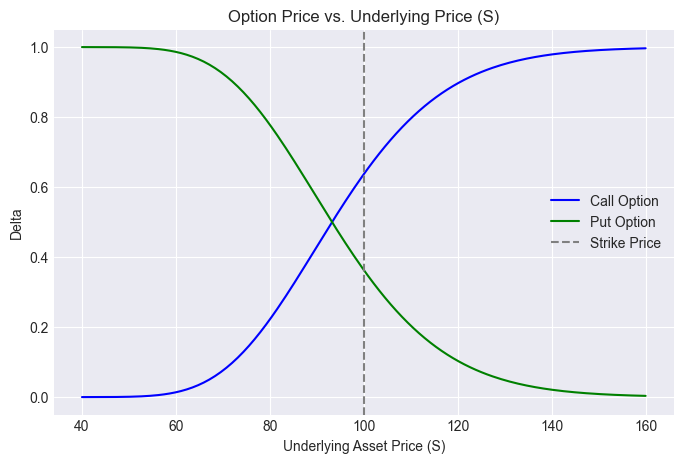

In [4]:
S_vals = np.linspace(40, 160, 200)
K = 100
T = 1
r = 0.05
sigma = 0.2

call_prices = [delta(S, K, T, r, sigma, "call") for S in S_vals]
put_prices = [delta(S, K, T, r, sigma, "put") for S in S_vals]

plt.figure(figsize=(8,5))
plt.plot(S_vals, call_prices, label="Call Option", color="blue")
plt.plot(S_vals, put_prices, label="Put Option", color="green")
plt.axvline(K, linestyle="--", color="gray", label="Strike Price")
plt.title("Option Price vs. Underlying Price (S)")
plt.xlabel("Underlying Asset Price (S)")
plt.ylabel("Delta")
plt.legend()
plt.grid(True)
plt.show()

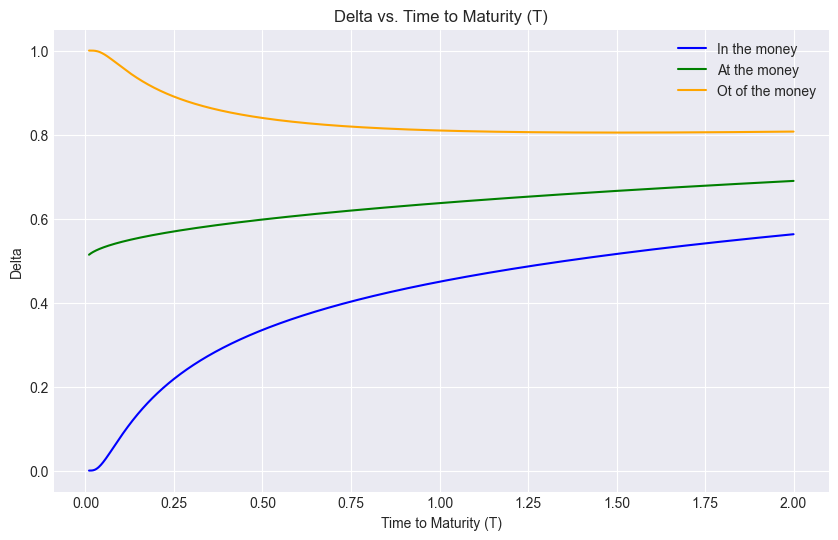

In [ ]:
T_vals = np.linspace(0.01, 2, 1000)
S = 100

in_the_money = [delta(S, 110, T, r, sigma, "call") for T in T_vals]
at_the_money = [delta(S, 100, T, r, sigma, "call") for T in T_vals]
out_of_the_money = [delta(S, 90, T, r , sigma, "call") for T in T_vals]

plt.figure(figsize=(10,6))
plt.plot(T_vals, in_the_money, label="In the money", color="blue")
plt.plot(T_vals, at_the_money, label="At the money", color="green")
plt.plot(T_vals, out_of_the_money, label="Out of the money", color="orange")
plt.title("Delta vs. Time to Maturity (T)")
plt.xlabel("Time to Maturity (T)")
plt.ylabel("Delta")
plt.legend()
plt.grid(True)
plt.show() 